In [1]:
#install packages
import idaes
import pyomo.environ as pyo
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import pandas as pd
import time
from pint import UnitRegistry
from membrane_reactor_v2 import create_model
from membrane_reactor_v2 import toggle_reaction_off, toggle_reaction_on, init_reaction_rate  
from membrane_reactor_v2 import conc_profile_multiple
from membrane_reactor_v2 import print_streams
from membrane_reactor_v2 import check_finite_element_mass_balance
from membrane_reactor_v2 import fix_temperature, unfix_temperature
from membrane_reactor_v2 import CO_conversion, H2_recovery, feed_utilization_efficiency

## Data sets

In [2]:
# Specify case based on input dataset.
# # PCI-10: bench-scale laboratory  data supplied by PCI - 
# # PCI-H2A: bench-scale laboratory data on membrane performance combined with industrial gas properties from the NREL H2A model report - 
# #            corresponds to dataset in Table 3 in paper
# # public: data published in Brunetti 2007 https://doi.org/10.1016/j.memsci.2007.09.009
# # public-H2A: membrane perfromance data from Brunetti 2007 combined with industrial gas properties from the NREL H2A model report

case = 'PCI-H2A'
savefig = False

In [3]:
# read data from json file
data_path = 'WGSMR_data_{}'.format(case)
with open(data_path, 'r') as source_file:
    data = json.load(source_file)

In [4]:
def flowrate_to_ghsv(F0):
    P = 101325
    V = data['vol_reactor']
    R = 8.3145
    T = 273
    return 3600*R*T*F0/(P*V)

In [5]:
feed = data['feed_flow']
ghsv = flowrate_to_ghsv(feed)
print('feed =',feed,'GHSV =',ghsv)

feed = 0.00138 GHSV = 2831.8562828778227


## Create Model

In [6]:
input_mode = "flowrate" # "flowrate" or "GHSV" or "ghsv"

In [7]:
# create model instance 
m = create_model(temp_retentate=data['temp_retentate'],
CO_comp_feed=data['CO_comp_feed'],
H2O_comp_feed=data['H2O_comp_feed'],
CO2_comp_feed=data['CO2_comp_feed'],
H2_comp_feed=data['H2_comp_feed'],
CH4_comp_feed=data['CH4_comp_feed'],
N2_comp_feed=data['N2_comp_feed'],
feed_pressure=data['feed_pressure'],
feed_flow = data['feed_flow'],
pressure_drop_retentate=data['pressure_drop_retentate'],
sweep_pressure=data['sweep_pressure'],
pre_exponent=data['pre_exponent'],
E_R=data['E_R'],
pressure_exponent=data['pressure_exponent'],
vol_reactor=data['vol_reactor'],
area_membrane=data['area_membrane'],
rho_catalyst=data['rho_catalyst'],
feed_input_mode=input_mode,
with_reaction=True,
initialize_pressure_strategy="constant",
discretize_temperature=False,
) #feed_pressure=3.5e6


In [8]:
m.T.fix(data['temp_retentate'])
if input_mode == "GHSV" or input_mode == "ghsv":
    m.ghsv.fix(ghsv)

In [9]:
assert type(m) == pyo.pyomo.core.base.PyomoModel.ConcreteModel, "Did not create model"

In [10]:
# define solver
model_solver = pyo.SolverFactory('ipopt')
model_solver.options['halt_on_ampl_error'] ='yes'


## Initialize Model

In [11]:
# deactivate reaction
toggle_reaction_off(m)

In [12]:
# start timer
time_start = time.perf_counter()

# solve model without reaction
results = model_solver.solve(m, tee=True)

# print solve time
print("\nTime elasped =", time.perf_counter()-time_start,"secs")

Ipopt 3.13.2: halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        c

In [13]:
print(results)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 520
  Number of variables: 520
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.18076062202453613
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Solve Full Model

In [14]:
# toggle reaction on
toggle_reaction_on(m)

In [15]:
# initialize reaction rate
init_reaction_rate(m)

In [16]:
# start timer
time_start = time.perf_counter()

# solve full model
results = model_solver.solve(m, tee=True)

# print solve time
print("Time elasped =", time.perf_counter()-time_start,"CPU secs")

# resolve full model
results = model_solver.solve(m, tee=True)

Ipopt 3.13.2: halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        c

In [17]:
m.pprint()

11 Set Declarations
    COMPONENTS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {'CO', 'H2O', 'CO2', 'H2', 'CH4', 'N2'}
    ELEMENTS : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   20 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
    N_flux_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : ELEMENTS*COMPONENTS :  120 : {(0, 'CO'), (0, 'H2O'), (0, 'CO2'), (0, 'H2'), (0, 'CH4'), (0, 'N2'), (1, 'CO'), (1, 'H2O'), (1, 'CO2'), (1, 'H2'), (1, 'CH4'), (1, 'N2'), (2, 'CO'), (2, 'H2O'), (2, 'CO2'), (2, 'H2'), (2, 'CH4'), (2, 'N2'), (3, 'CO'), (3, 'H2O'), (3, 'CO2'), (3, 'H2'), (3, 'CH4'), (3, 'N2'), (4, 'CO'), (4, 'H2O'), (4, 'CO2'), (4, 'H2'), (4, 'CH4'), (4, 'N2'), (5, 'CO'), (5, 'H2O'), (5, 'CO2'), (5, 'H2'), (5, 'CH4'), (5, 'N2'), (6, 'CO'),

        Key         : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                               : Upper : Active
         (0, 'CH4') :   0.0 :                                                                                                                                                                                                                                                                                  flow_permeate[0,CH4] - (flow_permeate[1,CH4] + 0.0*0.00013550000000000001*(1/(flow_feed[CO] + flow_feed[H2O] + flow_feed[CO2] + flow_feed[H2] + flow_feed[CH4] + flow_feed[N2]))) :   0.0 :   True
    

        Key         : Lower : Body                                                                                                                                                                                                      : Upper : Active
         (0, 'CH4') :   0.0 :         composition_retentate[0,CH4]*(flow_retentate[0,CO] + flow_retentate[0,H2O] + flow_retentate[0,CO2] + flow_retentate[0,H2] + flow_retentate[0,CH4] + flow_retentate[0,N2]) - flow_retentate[0,CH4] :   0.0 :   True
          (0, 'CO') :   0.0 :           composition_retentate[0,CO]*(flow_retentate[0,CO] + flow_retentate[0,H2O] + flow_retentate[0,CO2] + flow_retentate[0,H2] + flow_retentate[0,CH4] + flow_retentate[0,N2]) - flow_retentate[0,CO] :   0.0 :   True
         (0, 'CO2') :   0.0 :         composition_retentate[0,CO2]*(flow_retentate[0,CO] + flow_retentate[0,H2O] + flow_retentate[0,CO2] + flow_retentate[0,H2] + flow_retentate[0,CH4] + flow_retentate[0,N2]) - flow_retentate[0,CO2] :   0.0 :   True
    

## Explore Solution

In [18]:
# feed utilization efficiency
print('Feed utilization efficiency =',feed_utilization_efficiency(m),'%')

Feed utilization efficiency = 80.85282890192327 %


In [19]:
# H2 recovery
print("H2 recovery =",H2_recovery(m),"%")

H2 recovery = 95.07505241222619 %


In [20]:
# CO conversion
print('CO conversion =',CO_conversion(m))

CO conversion = 99.29248648604721


In [21]:
with_SMR = True

In [22]:
if with_SMR:
    # total feed
    if 'ghsv' in m.component_map(pyo.Var):
        P = 101325 # stanadard pressure (Pa)
        V = m.volume()*m.N # entire reactor volume
        R = 8.3145 # gas constant (J/mol/K)
        T = 273 # standard temperature (K)
        total_feed =  P*V*pyo.value(m.ghsv)/(3600*R*T)
    else:
        total_feed = pyo.value(m.total_feed)
    
    # Excpected recovery with SMR
    # Assumption: All H2 produced by SMR is collected in the permeate
    H2_from_WGS = pyo.value(m.flow_permeate[m.ELEMENTS.first(),'H2'])*total_feed # H2 from WGS collected in the permeate
    H2_from_SMR = 4*pyo.value(m.y_feed['CH4'])*total_feed
    H2_in_retentate = pyo.value(m.flow_retentate[m.ELEMENTS.last(),'H2'])*total_feed
    expected_recovery = (H2_from_WGS+H2_from_SMR)/(H2_from_WGS+H2_from_SMR+H2_in_retentate)*100
    print("Expected H2 recovery with 90% SMR =",expected_recovery,"%")

Expected H2 recovery with 90% SMR = 95.80524504807626 %


## Print Stream Tables

In [23]:
print_stream = True

In [24]:
if print_stream:
    streams = print_streams(m, stream='retentate',save_data=False)

In [25]:
if print_stream:
    print(streams.head(10))

                          0         1         2         3         4   \
CO_flow [mol/s]     0.040149  0.018023  0.009811  0.006003  0.003878   
CO_comp [mol/mol]   0.044540  0.022161  0.013258  0.008783  0.006030   
H2O_flow [mol/s]    0.339849  0.317723  0.309511  0.305703  0.303578   
H2O_comp [mol/mol]  0.377010  0.390666  0.418239  0.447312  0.472085   
CO2_flow [mol/s]    0.201251  0.223377  0.231589  0.235397  0.237522   
CO2_comp [mol/mol]  0.223256  0.274659  0.312943  0.344440  0.369364   
H2_flow [mol/s]     0.301083  0.235063  0.170024  0.117218  0.078979   
H2_comp [mol/mol]   0.334005  0.289029  0.229751  0.171517  0.122818   
CH4_flow [mol/s]    0.019100  0.019100  0.019100  0.019100  0.019100   
CH4_comp [mol/mol]  0.021188  0.023485  0.025810  0.027948  0.029702   

                          5         6         7         8         9   \
CO_flow [mol/s]     0.002588  0.001804  0.001345  0.001087  0.000949   
CO_comp [mol/mol]   0.004197  0.003003  0.002272  0.001852  0.0

In [26]:
if print_stream:
    streams2 = print_streams(m, stream='permeate',save_data=False)

In [27]:
if print_stream:
    print(streams2.head(10))

                              0             1             2             3   \
CO_flow [mol/s]     0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
CO_comp [mol/mol]   5.473506e-17  1.076978e-16  2.589886e-16  7.943296e-16   
H2O_flow [mol/s]    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
H2O_comp [mol/mol]  5.473506e-17  1.076978e-16  2.589886e-16  7.943296e-16   
CO2_flow [mol/s]    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
CO2_comp [mol/mol]  5.473506e-17  1.076978e-16  2.589886e-16  7.943296e-16   
H2_flow [mol/s]     4.172814e-01  3.188140e-01  2.306680e-01  1.574160e-01   
H2_comp [mol/mol]   1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
CH4_flow [mol/s]    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
CH4_comp [mol/mol]  5.473506e-17  1.076978e-16  2.589886e-16  7.943296e-16   

                              4             5             6             7   \
CO_flow [mol/s]     0.000000e+00  0.000000e+00  0.000000e+00  0

## Check Material Balances

In [28]:
check_mass_bal = True

In [29]:
if check_mass_bal:
    check_finite_element_mass_balance(m,'ret',print_level=1)

Element 0
Atom  H  residual= -2.1461759999985e-07
Atom  C  residual= -3.594900000001167e-08
Atom  O  residual= -1.0798500000007991e-07
Atom  N  residual= 0.0
 
Element 1
Atom  H  residual= -5.421010862427522e-20
Atom  C  residual= -1.3552527156068805e-20
Atom  O  residual= -1.3552527156068805e-20
Atom  N  residual= 0.0
 
Element 2
Atom  H  residual= 1.8973538018496328e-19
Atom  C  residual= 2.371692252312041e-20
Atom  O  residual= 2.371692252312041e-20
Atom  N  residual= 0.0
 
Element 3
Atom  H  residual= 1.3552527156068805e-19
Atom  C  residual= -2.371692252312041e-20
Atom  O  residual= -7.792703114739563e-20
Atom  N  residual= 0.0
 
Element 4
Atom  H  residual= 1.8973538018496328e-19
Atom  C  residual= 4.1504614415460717e-20
Atom  O  residual= 1.4992483166401116e-19
Atom  N  residual= 0.0
 
Element 5
Atom  H  residual= -2.710505431213761e-20
Atom  C  residual= -4.362219678359647e-20
Atom  O  residual= -9.783230540787169e-20
Atom  N  residual= 0.0
 
Element 6
Atom  H  residual= -1.355

In [30]:
if check_mass_bal:
    check_finite_element_mass_balance(m,'perm',print_level=1)

Element 0
Atom  H  residual= -2.710505431213761e-19
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 1
Atom  H  residual= 5.421010862427522e-20
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 2
Atom  H  residual= -2.439454888092385e-19
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 3
Atom  H  residual= -1.8973538018496328e-19
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 4
Atom  H  residual= -2.710505431213761e-20
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 5
Atom  H  residual= -1.3552527156068805e-20
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 6
Atom  H  residual= 4.743384504624082e-20
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 7
Atom  H  residual= -8.470329472543003e-20
Atom  C  residual= 0.0
Atom  O  residual= 0.0
Atom  N  residual= 0.0
 
Element 8
Atom  

## Visualize permeation

In [31]:
conc_profile = True

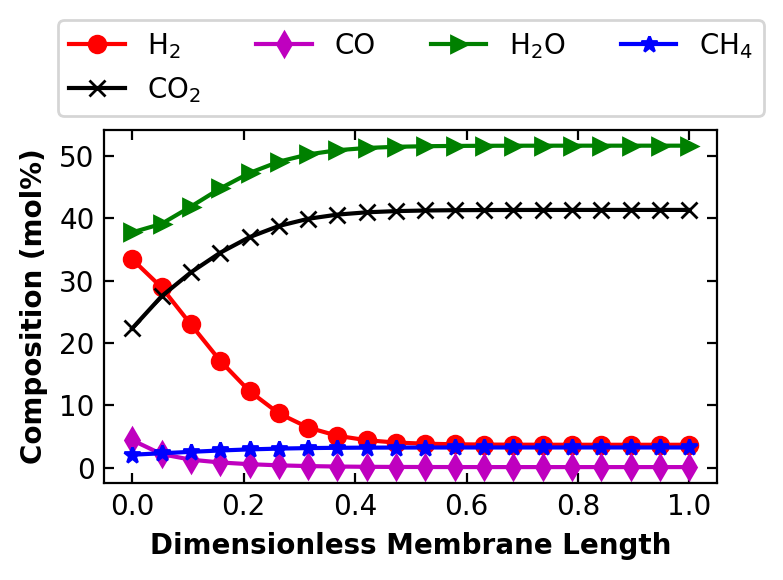

In [32]:
if conc_profile:
    conc_profile_multiple(m,sweep=False, methane=True, save_plot=False)